In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import skimage.io
import skimage.draw
from skimage.draw import polygon
from skimage.transform import resize
import json
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn

# EXP-1

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout = False, rate = 0.0):
        super(DoubleConv, self).__init__()
        self.dropout = dropout
        self.rate = rate
        if self.dropout == False:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(p=rate),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)
    
class W_up_Block(nn.Module):
    def __init__(self, in_channels,intermediate_channels, out_channels):
        super(W_up_Block,self).__init__()
        self.double_conv = DoubleConv(in_channels, intermediate_channels)
        self.up_sample =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self,x):
        conv = self.double_conv(x)
        x = self.up_sample(conv)
        return x, conv
    
class W_down_Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, out_channels, dropout, dropout_rate):
        super(W_down_Block,self).__init__()
        self.double_conv1 = ResBlock(in_channels, intermediate_channels)
        self.double_conv2 = DoubleConv(intermediate_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
        
    def forward(self, x, skip_input):
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv1(x)
        out = self.down_sample(x)
        final = self.double_conv2(out)
        return (final,x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False, dropout_rate=0.0):
        super(ResBlock,self).__init__()
        self.double_conv1 = nn.Conv2d(in_channels, 1, kernel_size = 1)
        self.double_conv2 = DoubleConv(in_channels, out_channels, dropout = True, rate = 0.2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x_skip = x
        x_skip = self.double_conv1(x_skip)
        x = self.double_conv2(x)
        x = torch.add(x,x_skip)
        x = self.relu(x)
        return x
    
class W_up_Block(nn.Module):
    def __init__(self, in_channels,intermediate_channels, out_channels, ):
        super(W_up_Block,self).__init__()
        self.double_conv = DoubleConv(in_channels, intermediate_channels)
        self.up_sample =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self,x):
        x = self.double_conv(x)
        x = self.up_sample(x)
        return x
    
class SandE(nn.Module):
    def __init__(self, filter_size, input_filter, rate):
        super(SandE,self).__init__()
        self.gap = nn.AvgPool2d(kernel_size=filter_size)
        self.flat = nn.Flatten()
        self.dense1 = nn.Linear(input_filter, int(input_filter*rate))
        self.relu = nn.ReLU(inplace=True)
        self.dense2 = nn.Linear(int(input_filter*rate), input_filter)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        copy = x
        x = self.gap(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        x = torch.mul(copy,torch.unsqueeze(torch.unsqueeze(x,2),3))
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self,input_dim, se_rate, dropout = False, dropout_rate = 0.0, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.input_dim = input_dim
        self.se_rate = se_rate
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Transient Block
        self.w_conv1 = W_up_Block(512, 1024, 512)
        self.attenw = SandE(int(input_dim/(2**3)), 512, self.se_rate)
        self.w_conv2 = W_down_Block(512 + 1024, 512, 1024, self.dropout, self.dropout_rate)
        # Upsampling Path
        self.atten4 = SandE(int(input_dim/(2**3)), 512, self.se_rate)
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.atten3 = SandE(int(input_dim/(2**2)), 256, self.se_rate)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.atten2 = SandE(int(input_dim/(2**1)), 128, self.se_rate)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.atten1 = SandE(int(input_dim), 64, self.se_rate)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        #print(skip4_out.shape)
        #print(x.shape)
        x = self.w_conv1(x)
        #print(x.shape)
        #print(g.shape)
        #print(skip4_out.shape)
        a = self.attenw(skip4_out)
        #print(x.shape,a.shape)
        x, skipw_out = self.w_conv2(x,a)
        #print(x.shape)
        #print(skipw_out.shape)
        a = self.atten4(skipw_out)
        x = self.up_conv4(x, a)
        a = self.atten3(skip3_out)
        x = self.up_conv3(x, a)
        a = self.atten2(skip2_out)
        x = self.up_conv2(x, a)
        a = self.atten1(skip1_out)
        x = self.up_conv1(x, a)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet(input_dim=128, se_rate = 0.2)

# Original Code

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout = False, rate = 0.0):
        super(DoubleConv, self).__init__()
        self.dropout = dropout
        self.rate = rate
        if self.dropout == False:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(p=rate),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)
    
class W_up_Block(nn.Module):
    def __init__(self, in_channels,intermediate_channels, out_channels):
        super(W_up_Block,self).__init__()
        self.double_conv = DoubleConv(in_channels, intermediate_channels)
        self.up_sample =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self,x):
        conv = self.double_conv(x)
        x = self.up_sample(conv)
        return x, conv
    
class W_down_Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, out_channels, dropout, dropout_rate):
        super(W_down_Block,self).__init__()
        self.double_conv1 = ResBlock(in_channels, intermediate_channels)
        self.double_conv2 = DoubleConv(intermediate_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
        
    def forward(self, x, skip_input):
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv1(x)
        out = self.down_sample(x)
        final = self.double_conv2(out)
        return (final,x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False, dropout_rate=0.0):
        super(ResBlock,self).__init__()
        self.double_conv1 = nn.Conv2d(in_channels, 1, kernel_size = 1)
        self.double_conv2 = DoubleConv(in_channels, out_channels, dropout = True, rate = 0.2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x_skip = x
        x_skip = self.double_conv1(x_skip)
        x = self.double_conv2(x)
        x = torch.add(x,x_skip)
        x = self.relu(x)
        return x
    
class W_up_Block(nn.Module):
    def __init__(self, in_channels,intermediate_channels, out_channels, ):
        super(W_up_Block,self).__init__()
        self.double_conv = DoubleConv(in_channels, intermediate_channels)
        self.up_sample =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self,x):
        x = self.double_conv(x)
        x = self.up_sample(x)
        return x
    
class SandE(nn.Module):
    def __init__(self, filter_size, input_filter):
        super(SandE,self).__init__()
        self.gap = nn.AvgPool2d(kernel_size=filter_size)
        self.flat = nn.Flatten()
        self.dense1 = nn.Linear(input_filter, 1)
        self.relu = nn.ReLU(inplace=True)
        self.dense2 = nn.Linear(1, input_filter)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        copy = x
        x = self.gap(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        x = torch.mul(copy,torch.unsqueeze(torch.unsqueeze(x,2),3))
        return x

In [94]:
i = torch.randn(1, 512, 16, 16)
m = ResBlock(512, 1024)
o = m(i)

torch.Size([1, 512, 16, 16])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1024, 16, 16])


In [28]:
128/16

8.0

In [49]:
o.shape

torch.Size([1, 512, 1, 1])

In [104]:
class UNet(nn.Module):
    def __init__(self,input_dim, dropout = False, dropout_rate = 0.0, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.input_dim = input_dim
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Transient Block
        self.w_conv1 = W_up_Block(512, 1024, 512)
        self.attenw = SandE(int(input_dim/(2**3)), 512)
        self.w_conv2 = W_down_Block(512 + 1024, 512, 1024, self.dropout, self.dropout_rate)
        # Upsampling Path
        self.atten4 = SandE(int(input_dim/(2**3)), 512)
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.atten3 = SandE(int(input_dim/(2**2)), 256)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.atten2 = SandE(int(input_dim/(2**1)), 128)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.atten1 = SandE(int(input_dim), 64)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        #print(skip4_out.shape)
        #print(x.shape)
        x = self.w_conv1(x)
        #print(x.shape)
        #print(g.shape)
        #print(skip4_out.shape)
        a = self.attenw(skip4_out)
        #print(x.shape,a.shape)
        x, skipw_out = self.w_conv2(x,a)
        #print(x.shape)
        #print(skipw_out.shape)
        a = self.atten4(skipw_out)
        x = self.up_conv4(x, a)
        a = self.atten3(skip3_out)
        x = self.up_conv3(x, a)
        a = self.atten2(skip2_out)
        x = self.up_conv2(x, a)
        a = self.atten1(skip1_out)
        x = self.up_conv1(x, a)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet(input_dim=128)

In [11]:
import torchmetrics
from torchmetrics.classification import Accuracy
TRAINING = True

# Set num of epochs
EPOCHS = 12

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define metrics
metrics = [
    Accuracy(task='binary'),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [12]:
model=model.to(DEVICE)

In [13]:
criterion=nn.BCELoss()

In [14]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import gc
from tqdm import tqdm

In [15]:
def two_roi(data,image,num):
    df_lmask=[]
    id=str(num)+'.png'
    x1=[data['_via_img_metadata'][id]['regions'][1]['shape_attributes']['all_points_x']]
    y1=[data['_via_img_metadata'][id]['regions'][1]['shape_attributes']['all_points_y']]
    x2=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_x']]
    y2=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_y']]
    poly=[]
    for i in range(len(x2[0])):
        poly.append((x2[0][i],y2[0][i]))
    poly.append((x2[0][0],y2[0][0]))
    for i in range(len(x1[0])):
        poly.append((x1[0][i],y1[0][i]))
    poly.append((x1[0][0],y1[0][0]))
    poly=np.array(poly) 
    mask = np.ones(shape=image.shape[0:2] ,dtype="bool")
    rr, cc = polygon(poly[:, 1], poly[:, 0], image.shape)
    mask[rr,cc]=0
    image[mask]=0
    return resize(mask,(IMG_HEIGHT,IMG_WIDTH,1))
    
def one_roi(data,image,num):
    df_lmask=[]
    id=str(num)+'.png'
    x1=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_x']]
    y1=[data['_via_img_metadata'][id]['regions'][0]['shape_attributes']['all_points_y']]
    poly=[]
    for i in range(len(x1[0])):
        poly.append((x1[0][i],y1[0][i]))
    poly.append((x1[0][0],y1[0][0]))
    poly=np.array(poly) 
    mask = np.ones(shape=image.shape[0:2] ,dtype="bool")
    rr, cc = polygon(poly[:, 1], poly[:, 0], image.shape)
    mask[rr,cc]=0
    image[mask]=0
    return resize(mask,(IMG_HEIGHT,IMG_WIDTH,1))

In [16]:
df_image=[]
df_mask=[]
mask_builder='collarbone'
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3
image_path="E:\\Attention UW-Net\\train_image\\images\\"
mask_path="E:\\Attention UW-Net\\train_data\\"+str(mask_builder)+"\\"
for i in range(150):
    df_image.append(resize(skimage.io.imread(image_path+str(i+1)+'.png'),(128,128,3)))
df_lmask=[]
for i in range(150):
    image = skimage.io.imread("E:\\Attention UW-Net\\train_image\\images\\1.png")
    f = open(mask_path+str(i+1)+'.json','r')
    data=json.load(f)
    if mask_builder == 'collarbone' or ' lungs':
        df_mask.append(two_roi(data,image,i+1))
    else:
        df_mask.append(one_roi(data,image,i+1))

In [17]:
X=(np.array(df_image)).reshape((len(df_image),IMG_HEIGHT,IMG_WIDTH,3))
Y=(np.array(df_mask)).reshape((len(df_mask),IMG_HEIGHT,IMG_WIDTH,1))
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.20, random_state=42)

In [18]:
class BuildingsDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
    def __getitem__(self, i):
        
        # read images and masks
        image=torch.Tensor(np.swapaxes(self.images[i],0,2))
        mask=torch.Tensor(np.swapaxes(self.masks[i].astype('uint8'),0,2))            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.images)

In [19]:
train_dataset = BuildingsDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = BuildingsDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [35]:
i=0
total =20
scheduler = lr_scheduler
for epoch in range(total):
    pbar = tqdm(train_loader);
    
    model.train()
    optimizer.zero_grad()
    running_loss=0.
    for (x, mask) in pbar:
        y_pred = nn.Sigmoid()(model(x.cuda()))
        loss = criterion(y_pred,
                         mask.cuda())
        running_loss += (loss.item())/len(train_loader)
        pbar.set_postfix({'Epoch': f'{epoch+1}/{total}',
                          'current_loss':f'{loss.item():.2f}'})
        loss.backward()
        optimizer.step()
        
        gc.collect()
        torch.cuda.empty_cache()
    #print(running_loss)
    scheduler.step(running_loss)
    with torch.no_grad():
        val_running_loss=0.
        vbar = tqdm(val_loader);
        if epoch%1==0:
            model.eval()
            for (y,mask) in vbar:
                y=y.cuda()
                pred_mask=mask.cuda()
                predict=nn.Sigmoid()(model(y))
                val_loss = criterion(predict,pred_mask)
                val_running_loss += (val_loss.item())/len(val_loader)
        vbar.set_postfix({'Epoch': f'{epoch+1}/{total}',
                          'current_loss':f'{val_loss.item():.2f}'})

100%|██████████| 2/2 [00:00<00:00, 16.23it/s]


In [36]:
x,y=val_loader.dataset.__getitem__(1)
y_output= model(x.reshape(1,3,128,128).cuda())

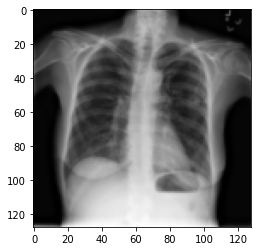

In [32]:
plt.imshow(x[0].T,cmap='gray')

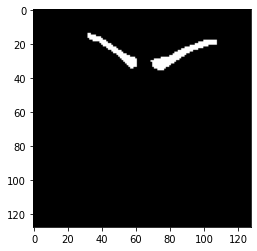

In [33]:
plt.imshow(1-y[0].T,cmap='gray')

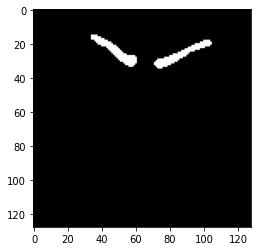

In [37]:
plt.imshow(1-(nn.Sigmoid()(y_output[0]).cpu().detach().numpy()[0].T)>0.5,cmap='gray')